# 1. EDA

## 1.0 Preparing

In [1]:
!pip install tqdm_joblib optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
import multiprocessing
from tqdm_joblib import tqdm_joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

<ipython-input-2-39f87d2e0e1b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
train_path = 'train.csv'
train_df = pd.read_csv(train_path)

In [4]:
train_df.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1292132,Land Rover Range Rover Velar 3.0A Si6 R-Dynami...,land rover,range,"1 owner, no repairs needed! it looks great, in...",2018.0,NaN,08-mar-2018,suv,parf car,...,96000.0,88906.0,132031.0,NaN,NaN,uncategorized,3l supercharged v6 p380 engine at 375bhp/450nm...,"2 x massage/memory/cooling & warmer seat, rear...",NaN,193788.0
1,1294696,Mercedes-Benz C-Class C200 Sport Premium Sunroof,mercedes-benz,c200,rare beautiful white c200 sport premium sunroo...,2017.0,NaN,28-dec-2017,luxury sedan,"parf car, premium ad car",...,85680.0,40678.0,43950.0,NaN,NaN,uncategorized,"2.0l 4 cylinders inline turbocharged engine, p...","multi function steering, electric tailgate, re...",NaN,96800.0
2,1311717,Honda Odyssey 2.4A (COE till 09/2027),honda,odyssey,comes with warranty. full service done.,2007.0,NaN,19-sep-2007,mpv,"coe car, premium ad car, low mileage car",...,138000.0,27994.0,30794.0,NaN,NaN,uncategorized,"2.4l k24a 4 cylinders inline dohc i-vtec, 5 sp...","cruise control, touchscreen audio, reverse cam...",NaN,39800.0
3,1310068,Toyota Corolla Altis 1.6A (COE till 12/2028),toyota,altis,0,2008.0,NaN,15-dec-2008,mid-sized sedan,"coe car, premium ad car",...,160000.0,16084.0,16084.0,NaN,NaN,uncategorized,super fuel efficient 1.6l 16 valves dohc vvt-i...,"leather seats, pioneer dvd audio system with r...",NaN,44800.0
4,1325280,Lexus GS300 (COE till 06/2026),lexus,gs,wear and tear done up. well maintained and reg...,2006.0,NaN,22-dec-2006,luxury sedan,"coe car, premium ad car",...,183000.0,50414.0,55456.0,NaN,NaN,uncategorized,"powerful 3.0l v6 engine, 227bhp, 6 speed , key...",premium upholstery electric seats. memory seat...,NaN,25800.0


In [5]:
print(f"The dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")

The dataset has 25000 rows and 30 columns.


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         25000 non-null  int64  
 1   title              25000 non-null  object 
 2   make               23684 non-null  object 
 3   model              25000 non-null  object 
 4   description        24320 non-null  object 
 5   manufactured       24993 non-null  float64
 6   original_reg_date  255 non-null    object 
 7   reg_date           25000 non-null  object 
 8   type_of_vehicle    25000 non-null  object 
 9   category           25000 non-null  object 
 10  transmission       25000 non-null  object 
 11  curb_weight        24693 non-null  float64
 12  power              22360 non-null  float64
 13  fuel_type          5879 non-null   object 
 14  engine_cap         24404 non-null  float64
 15  no_of_owners       24982 non-null  float64
 16  depreciation       244

In [7]:
# Check for missing data and calculate correlation with price
missing_info = train_df.isnull().sum().sort_values(ascending=False)
correlations = train_df.corr(numeric_only=True)['price'].sort_values(ascending=False)

# Combine the missing data and correlation information
missing_info_df = pd.DataFrame({
    'Missing_Count': missing_info,
    'Missing_Percentage': (missing_info / len(train_df)) * 100,
    'Correlation_with_Price': correlations
})

# Display the missing data and correlation
missing_info_df

,Missing_Count,Missing_Percentage,Correlation_with_Price
accessories,3813,15.252,NaN
arf,174,0.696,0.891877
category,0,0.000,NaN
coe,0,0.000,0.356526
curb_weight,307,1.228,0.152139
depreciation,507,2.028,0.811806
dereg_value,220,0.880,0.919632
description,680,2.720,NaN
eco_category,0,0.000,NaN
engine_cap,596,2.384,0.443110


In [8]:
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / train_df.shape[0]) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
missing_data

,Missing Values,Percentage
indicative_price,25000,100.000
opc_scheme,24838,99.352
original_reg_date,24745,98.980
lifespan,22671,90.684
fuel_type,19121,76.484
mileage,5304,21.216
accessories,3813,15.252
power,2640,10.560
road_tax,2632,10.528
make,1316,5.264


## 1.1 Drop description columns

In [9]:
train_df_dropped = train_df.drop(columns=['title', 'description', 'opc_scheme', 'indicative_price', 'lifespan', 'original_reg_date'])

## 1.2 Change string-based categorical columns into value-based

In [10]:
from sklearn.preprocessing import LabelEncoder

# List of columns to encode
categorical_columns = ['make', 'model', 'type_of_vehicle', 'transmission', 'fuel_type', 'eco_category']

# Apply Label Encoding to each categorical column
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train_df_dropped[col] = le.fit_transform(train_df_dropped[col].astype(str))
    label_encoders[col] = le  # Store encoder for future use or inverse transformation

In [11]:
train_df_dropped

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,coe,road_tax,dereg_value,mileage,omv,arf,eco_category,features,accessories,price
0,1292132,43,595,2018.0,08-mar-2018,8,parf car,0,1884.0,280.0,...,48011,2380.0,103323.0,96000.0,88906.0,132031.0,0,3l supercharged v6 p380 engine at 375bhp/450nm...,"2 x massage/memory/cooling & warmer seat, rear...",193788.0
1,1294696,51,192,2017.0,28-dec-2017,2,"parf car, premium ad car",0,1465.0,135.0,...,47002,1202.0,45179.0,85680.0,40678.0,43950.0,0,"2.0l 4 cylinders inline turbocharged engine, p...","multi function steering, electric tailgate, re...",96800.0
2,1311717,29,546,2007.0,19-sep-2007,4,"coe car, premium ad car, low mileage car",0,1648.0,118.0,...,50355,2442.0,16003.0,138000.0,27994.0,30794.0,0,"2.4l k24a 4 cylinders inline dohc i-vtec, 5 sp...","cruise control, touchscreen audio, reverse cam...",39800.0
3,1310068,89,156,2008.0,15-dec-2008,3,"coe car, premium ad car",0,1195.0,80.0,...,27571,1113.0,12184.0,160000.0,16084.0,16084.0,0,super fuel efficient 1.6l 16 valves dohc vvt-i...,"leather seats, pioneer dvd audio system with r...",44800.0
4,1325280,44,398,2006.0,22-dec-2006,2,"coe car, premium ad car",0,1660.0,183.0,...,48479,3570.0,9138.0,183000.0,50414.0,55456.0,0,"powerful 3.0l v6 engine, 227bhp, 6 speed , key...",premium upholstery electric seats. memory seat...,25800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1329201,51,191,2011.0,14-jul-2011,2,"coe car, premium ad car, low mileage car",0,1500.0,115.0,...,45272,1039.0,30921.0,94000.0,31019.0,31019.0,0,inline 4 16 valves rwd engine displacement 179...,new battery new throttle body new recording ca...,85000.0
24996,1285898,6,182,2018.0,29-apr-2020,8,"parf car, direct owner sale, rare & exotic",0,2470.0,404.0,...,37500,3944.0,NaN,73838.0,137136.0,218845.0,0,"4.0 liter twin turbocharged v8 engine, produci...","panoramic roof, 8""touchscreen display, navigat...",412888.0
24997,1306309,51,129,2014.0,01-apr-2015,1,"parf car, premium ad car, low mileage car, sgc...",0,1395.0,90.0,...,61410,740.0,11890.0,88388.0,22897.0,14056.0,0,1.6l inline 4 turbocharged engine with 7 speed...,"dual electric seats with 3 memory settings, di...",23888.0
24998,1306902,4,132,2017.0,30-jun-2017,1,parf car,0,1275.0,85.0,...,46489,392.0,24070.0,94900.0,23772.0,15281.0,0,"fuel efficient 3 cylinder turbocharged engine,...","bbs sport rim, audi mmi/bluetooth/audio sound ...",53300.0


## 1.3 Check category column

In [12]:
unique_categories = set()

# Iterate through each entry in the 'category' column and add unique categories
for entry in train_df_dropped['category'].dropna():
    categories = [cat.strip() for cat in entry.split(',')]
    unique_categories.update(categories)

# Display the unique categories
unique_categories_count = len(unique_categories)
unique_categories_list = list(unique_categories)

unique_categories_count, unique_categories_list

(16,
 ['consignment car',
  'imported used vehicle',
  'sta evaluated car',
  'parf car',
  'sgcarmart warranty cars',
  'opc car',
  'low mileage car',
  'rare & exotic',
  'vintage cars',
  'direct owner sale',
  'electric cars',
  'almost new car',
  '-',
  'premium ad car',
  'coe car',
  'hybrid cars'])

In [13]:
train_df_dropped['category'] = train_df_dropped['category'].replace('-', pd.NA)

## 1.4 Check outlier (Eye-ball match)

<ipython-input-14-0fbcea23e1c4>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df_dropped['reg_date'] = pd.to_datetime(train_df_dropped['reg_date'], errors='coerce')


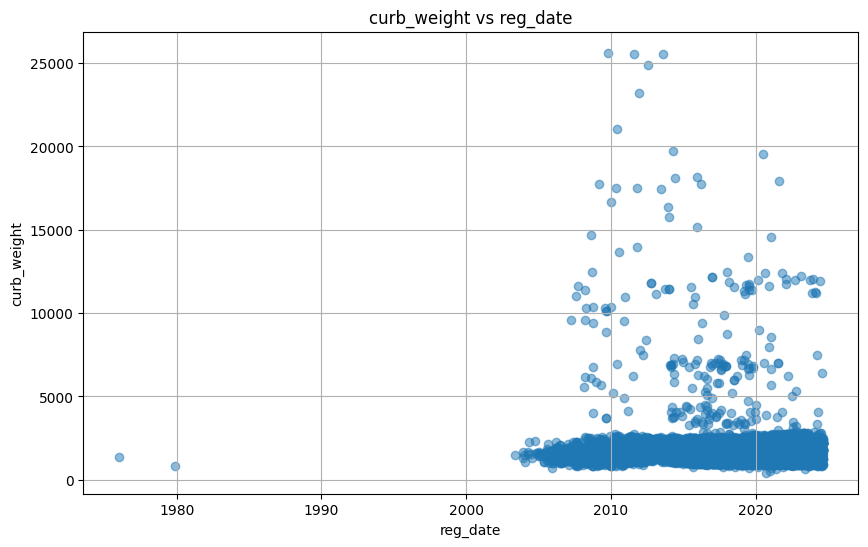

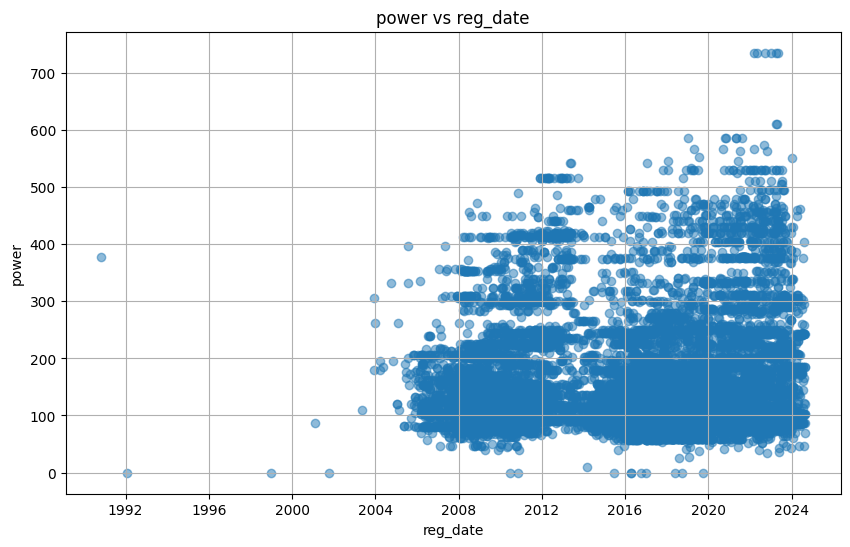

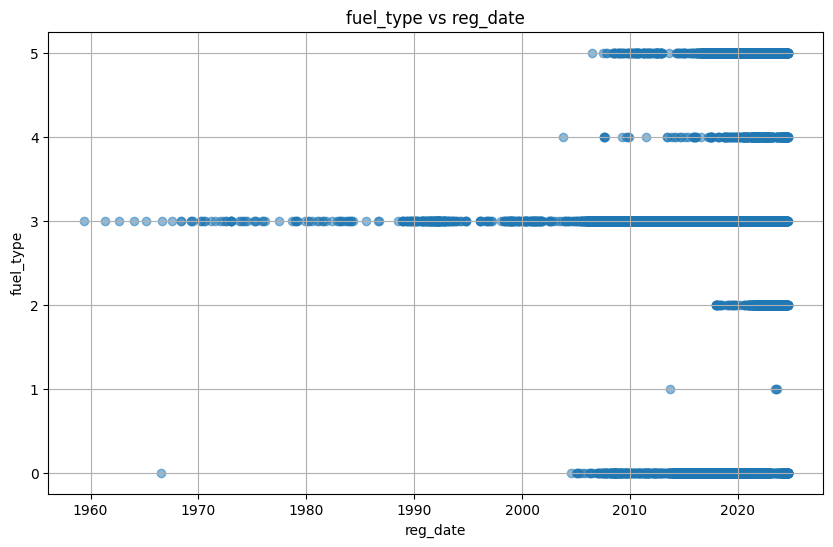

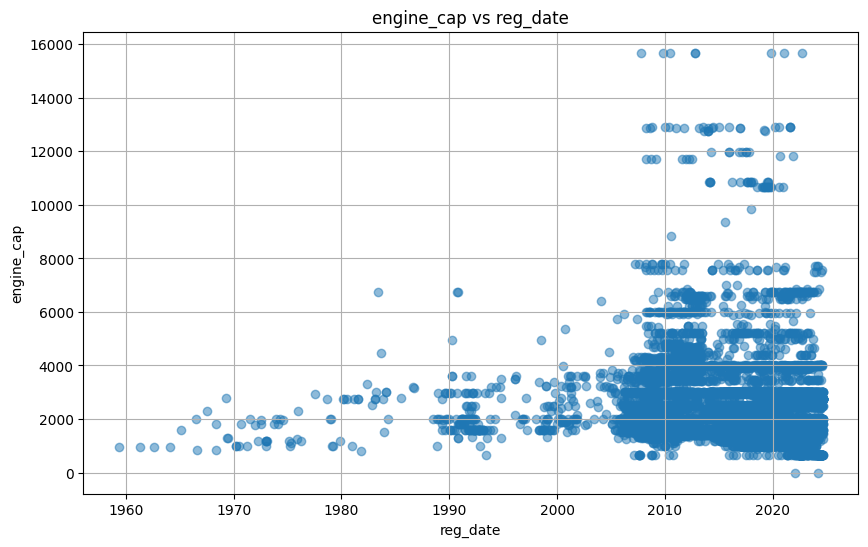

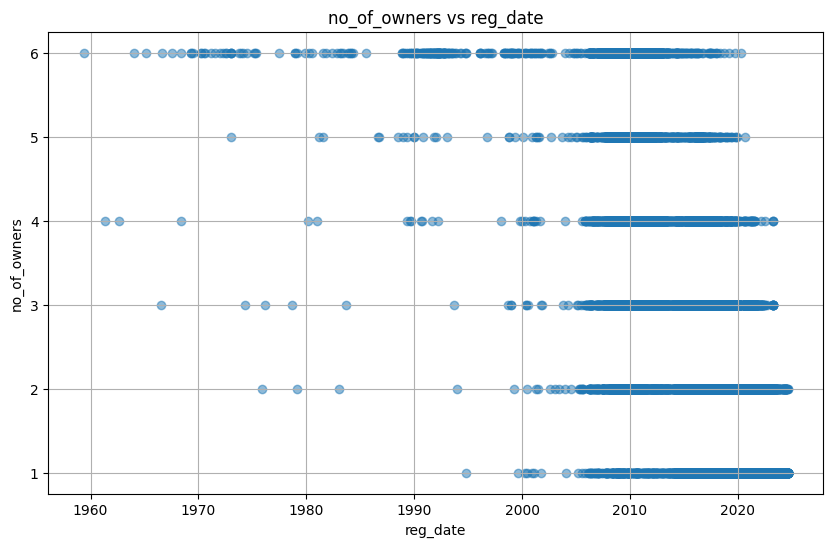

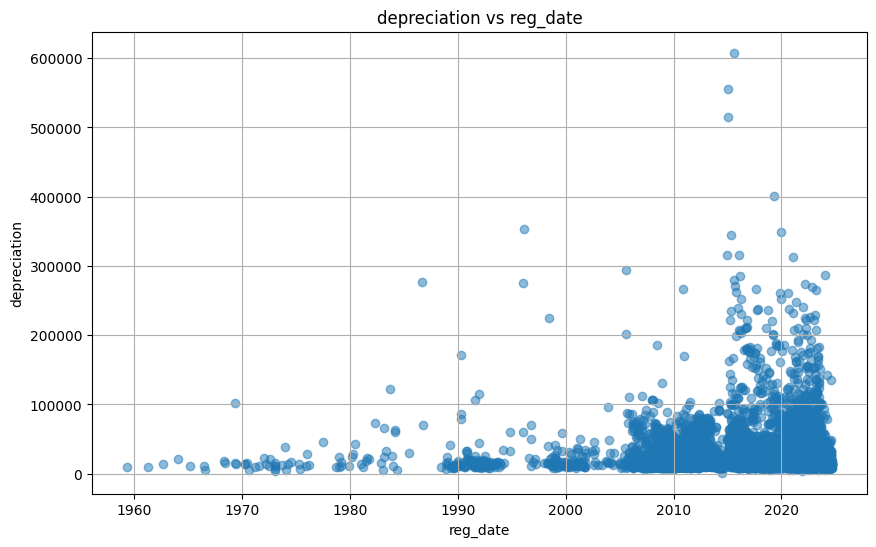

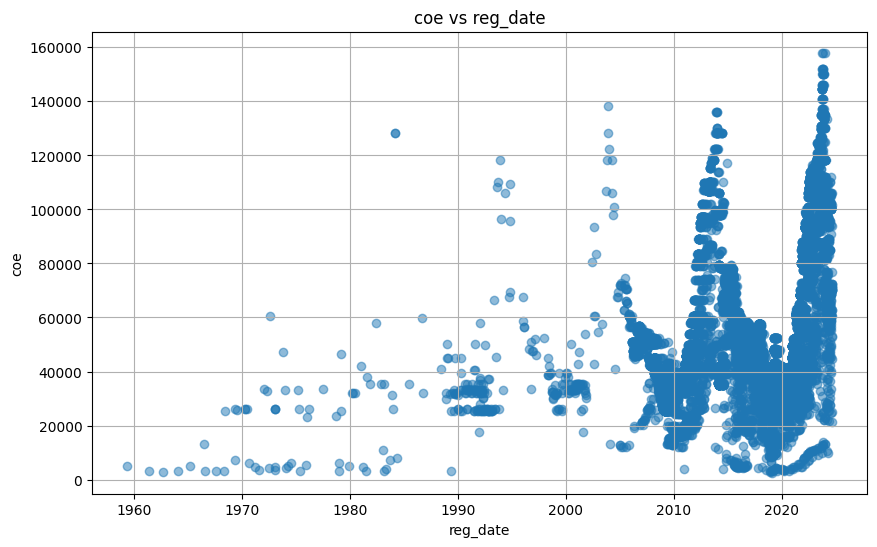

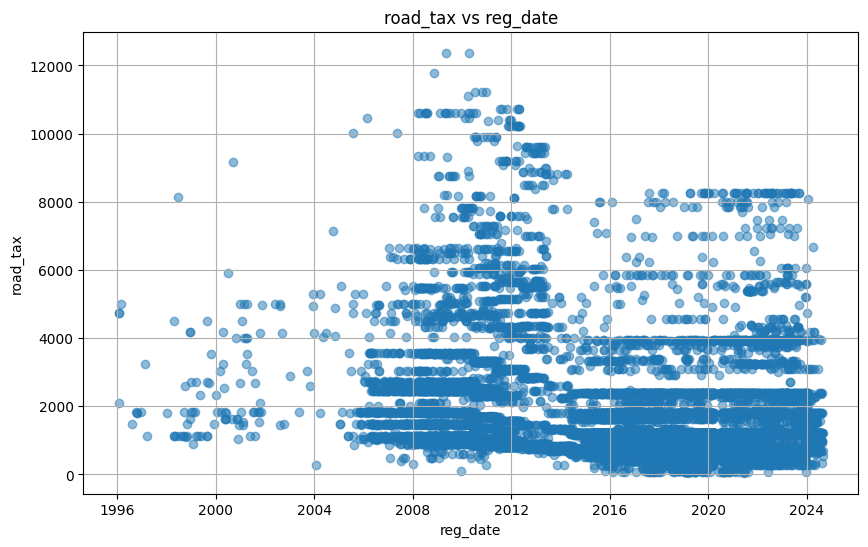

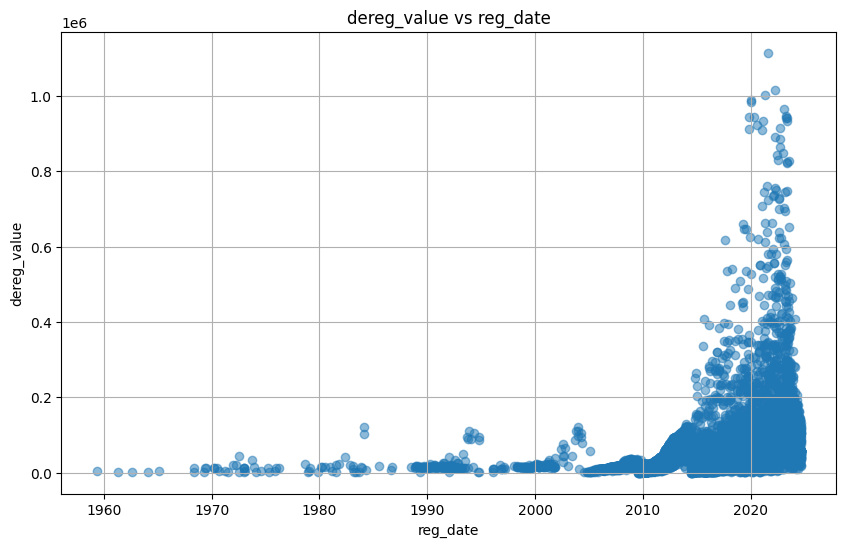

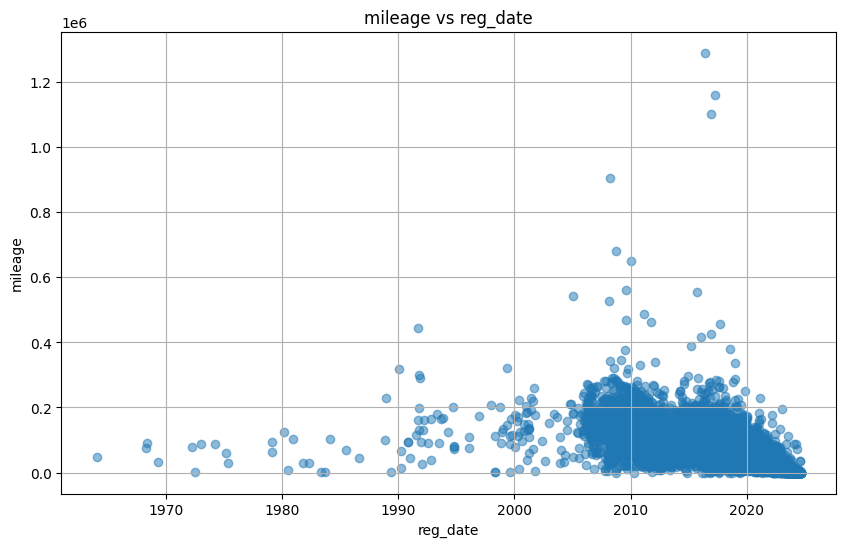

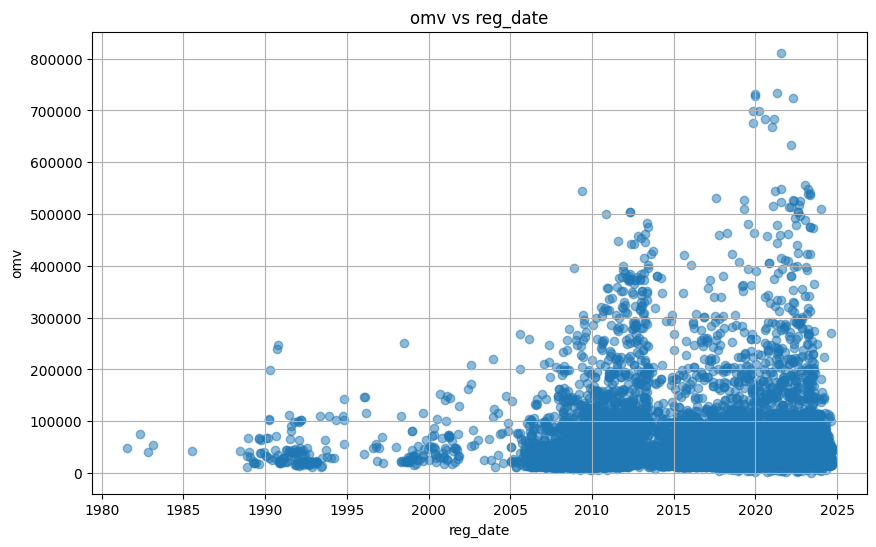

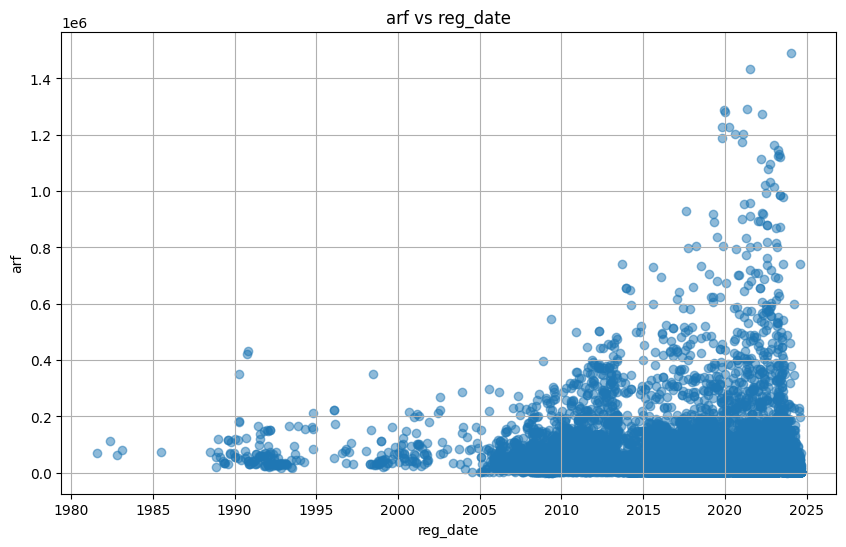

In [14]:
import matplotlib.pyplot as plt

# Convert 'reg_date' to datetime format
train_df_dropped['reg_date'] = pd.to_datetime(train_df_dropped['reg_date'], errors='coerce')

# List of columns to plot
columns_to_plot = ['curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners',
                   'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf']

# Plot each column with 'reg_date' on the x-axis
for col in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.scatter(train_df_dropped['reg_date'], train_df_dropped[col], alpha=0.5, marker='o')
    plt.title(f'{col} vs reg_date')
    plt.xlabel('reg_date')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()


In [15]:
# Filter rows where 'depreciation' is greater than 300000
high_depreciation_rows = train_df_dropped[train_df_dropped['depreciation'] > 300000]

selected_columns = [
    'listing_id', 'make', 'model', 'manufactured', 'reg_date', 'type_of_vehicle',
    'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
    'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage',
    'omv', 'arf', 'price'
]

# Filter the high depreciation rows with selected columns
high_depreciation_selected = high_depreciation_rows[selected_columns]

high_depreciation_selected

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,price
324,1236230,22,202,2014.0,2015-01-06,6,"parf car, low mileage car",0,1770.0,412.0,...,3855.0,4.0,514250.0,74389,3724.0,203330.0,28500.0,236858.0,398345.0,488000.0
2271,1245157,70,758,2015.0,2015-07-30,6,"parf car, rare & exotic, low mileage car",0,2435.0,465.0,...,6592.0,6.0,607730.0,71509,8004.0,336929.0,20000.0,347794.0,598030.0,980000.0
5500,1228180,70,561,2020.0,2021-02-09,2,"parf car, rare & exotic, low mileage car",0,2720.0,420.0,...,6749.0,2.0,312400.0,49489,8250.0,934163.0,5000.0,683397.0,1202120.0,2680000.0
8946,1220994,1,76,2014.0,2014-12-22,6,"parf car, premium ad car, low mileage car",0,920.0,177.0,...,1742.0,3.0,315330.0,72201,910.0,57593.0,50000.0,78175.0,107715.0,218000.0
10448,1300235,66,122,2014.0,2015-04-22,6,"parf car, low mileage car",0,1670.0,383.0,...,3800.0,3.0,344500.0,70500,3638.0,162290.0,84000.0,189224.0,312604.0,448888.0
11758,1298599,66,122,2013.0,2015-02-05,6,"parf car, rare & exotic, premium ad car, low m...",0,1430.0,350.0,...,3799.0,3.0,555200.0,76790,3636.0,136958.0,30000.0,162294.0,264130.0,488000.0
15662,1329900,70,561,2019.0,2019-12-24,2,"parf car, rare & exotic, low mileage car",0,2660.0,420.0,...,6749.0,1.0,349260.0,40101,8250.0,988210.0,11800.0,731785.0,1289210.0,2500000.0
16010,1141512,42,170,2019.0,2019-04-30,6,"parf car, rare & exotic, low mileage car",0,1640.0,566.0,...,6498.0,1.0,401120.0,52410,7856.0,646327.0,3120.0,509947.0,889905.0,2400000.0
21806,1273670,70,758,2015.0,2016-01-28,6,"parf car, rare & exotic, low mileage car",0,2360.0,465.0,...,6592.0,4.0,315520.0,60689,8004.0,391664.0,25188.0,401250.0,694250.0,858000.0
24454,1151067,66,122,1995.0,1996-02-27,6,"coe car, rare & exotic",0,NaN,NaN,...,3600.0,6.0,352660.0,56436,4986.0,9602.0,NaN,115851.0,173777.0,600000.0


In [16]:
# Filter rows where 'road_tax' is greater than 12000
high_road_tax_rows = train_df_dropped[train_df_dropped['road_tax'] > 12000]

# Select the specific columns to display
high_road_tax_selected = high_road_tax_rows[selected_columns]

high_road_tax_selected

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,price
1788,1171295,70,561,2007.0,2010-04-23,2,"imported used vehicle, coe car, rare & exotic,...",0,2745.0,338.0,...,6749.0,2.0,82850.0,33568,12375.0,19653.0,48500.0,258255.0,258255.0,498000.0
19060,1288350,70,561,2009.0,2009-05-12,2,"coe car, premium ad car, low mileage car",0,2550.0,338.0,...,6749.0,6.0,89180.0,31933,12375.0,15039.0,46000.0,544305.0,544305.0,420000.0


In [17]:
# Filter rows where 'dereg_value' is greater than 1 million (1e6)
high_dereg_value_rows = train_df_dropped[train_df_dropped['dereg_value'] > 1e6]

# Select the specific columns to display
high_dereg_value_selected = high_dereg_value_rows[selected_columns]

high_dereg_value_selected


,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,price
976,1304066,70,561,2021.0,2021-05-03,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,2.0,247580.0,47806,8250.0,1002074.0,14000.0,733460.0,1292230.0,2350000.0
3169,1304909,70,561,2021.0,2021-07-19,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,1.0,193470.0,57700,8250.0,1114652.0,9000.0,811764.0,1433180.0,2088888.0
5299,1303347,70,561,2022.0,2022-04-09,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,1.0,210200.0,82501,8250.0,1016482.0,9000.0,723540.0,1274370.0,2280800.0


In [18]:
# Filter rows where 'mileage' is greater than 600,000 (0.6 * 1e6)
high_mileage_rows = train_df_dropped[train_df_dropped['mileage'] > 0.6 * 1e6]

# Select the specific columns to display
high_mileage_selected = high_mileage_rows[selected_columns]

high_mileage_selected

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,price
3072,1326321,8,23,2016.0,2016-05-27,4,parf car,0,1480.0,85.0,...,1496.0,3.0,14630.0,49501,1082.0,22719.0,1290000.0,30861.0,25206.0,38777.0
15772,1314610,34,480,2009.0,2009-12-29,0,"coe car, direct owner sale",0,10340.0,NaN,...,7790.0,3.0,15350.0,25577,NaN,13959.0,650000.0,102717.0,5136.0,83800.0
20825,1277607,54,607,2008.0,2008-10-10,0,coe car,1,4000.0,NaN,...,4899.0,6.0,12100.0,40188,NaN,16934.0,679468.0,68641.0,3433.0,51000.0
21757,1328176,84,551,2016.0,2016-11-22,8,"parf car, premium ad car",0,1684.0,129.0,...,2498.0,2.0,13010.0,56206,1798.0,28757.0,1100000.0,24807.0,26730.0,42800.0
22960,1288463,54,361,2008.0,2008-03-11,9,coe car,1,11400.0,NaN,...,12882.0,6.0,20280.0,40230,NaN,15034.0,903807.0,84112.0,4206.0,75800.0
23672,1330455,54,552,2016.0,2017-03-31,8,parf car,0,1625.0,123.0,...,2360.0,2.0,13440.0,53300,1636.0,28365.0,1158888.0,23141.0,24398.0,46800.0


In [19]:
# Filter rows where 'omv' is greater than 600,000
high_omv_rows = train_df_dropped[train_df_dropped['omv'] > 600000]

# Select the specific columns to display
high_omv_selected = high_omv_rows[selected_columns]

high_omv_selected

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,price
976,1304066,70,561,2021.0,2021-05-03,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,2.0,247580.0,47806,8250.0,1002074.0,14000.0,733460.0,1292230.0,2350000.0
3169,1304909,70,561,2021.0,2021-07-19,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,1.0,193470.0,57700,8250.0,1114652.0,9000.0,811764.0,1433180.0,2088888.0
4235,1326787,70,561,2019.0,2019-10-29,2,"parf car, rare & exotic, premium ad car, low m...",0,2660.0,420.0,...,6749.0,4.0,185680.0,40000,8250.0,942520.0,23000.0,698313.0,1228960.0,1580000.0
5299,1303347,70,561,2022.0,2022-04-09,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,1.0,210200.0,82501,8250.0,1016482.0,9000.0,723540.0,1274370.0,2280800.0
5500,1228180,70,561,2020.0,2021-02-09,2,"parf car, rare & exotic, low mileage car",0,2720.0,420.0,...,6749.0,2.0,312400.0,49489,8250.0,934163.0,5000.0,683397.0,1202120.0,2680000.0
7360,1305378,70,561,2020.0,2020-03-30,2,"parf car, rare & exotic, low mileage car",0,2660.0,420.0,...,6749.0,1.0,185590.0,37989,8250.0,942569.0,6400.0,698319.0,1228980.0,1688888.0
8903,1322655,70,561,2019.0,2019-12-27,2,"parf car, rare & exotic, low mileage car",0,2660.0,420.0,...,6749.0,1.0,252770.0,40101,8250.0,982459.0,23800.0,727326.0,1281190.0,2000000.0
14923,1315369,70,561,2020.0,2020-08-08,2,"parf car, low mileage car",0,2660.0,420.0,...,6749.0,1.0,260200.0,35001,8250.0,923700.0,20158.0,684067.0,1203320.0,2180000.0
15662,1329900,70,561,2019.0,2019-12-24,2,"parf car, rare & exotic, low mileage car",0,2660.0,420.0,...,6749.0,1.0,349260.0,40101,8250.0,988210.0,11800.0,731785.0,1289210.0,2500000.0
16742,1252226,70,561,2020.0,2021-01-11,2,"parf car, rare & exotic, premium ad car, low m...",0,2660.0,420.0,...,6749.0,1.0,178300.0,41503,8250.0,908460.0,18000.0,668490.0,1175280.0,1760000.0


In [20]:
# Filter rows where 'arf' is greater than 1,100,000 (1.1e6)
high_arf_rows = train_df_dropped[train_df_dropped['arf'] > 1.1e6]

# Select the specific columns to display
high_arf_selected = high_arf_rows[selected_columns]

high_arf_selected

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,price
976,1304066,70,561,2021.0,2021-05-03,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,2.0,247580.0,47806,8250.0,1002074.0,14000.0,733460.0,1292230.0,2350000.0
3169,1304909,70,561,2021.0,2021-07-19,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,1.0,193470.0,57700,8250.0,1114652.0,9000.0,811764.0,1433180.0,2088888.0
3206,1316395,70,676,2023.0,2024-01-15,8,"parf car, rare & exotic, almost new car, premi...",0,2890.0,550.0,...,NaN,1.0,286950.0,85010,8090.0,128008.0,2300.0,509974.0,1491920.0,2788000.0
4235,1326787,70,561,2019.0,2019-10-29,2,"parf car, rare & exotic, premium ad car, low m...",0,2660.0,420.0,...,6749.0,4.0,185680.0,40000,8250.0,942520.0,23000.0,698313.0,1228960.0,1580000.0
5299,1303347,70,561,2022.0,2022-04-09,2,"parf car, rare & exotic, premium ad car, low m...",0,2720.0,420.0,...,6749.0,1.0,210200.0,82501,8250.0,1016482.0,9000.0,723540.0,1274370.0,2280800.0
5500,1228180,70,561,2020.0,2021-02-09,2,"parf car, rare & exotic, low mileage car",0,2720.0,420.0,...,6749.0,2.0,312400.0,49489,8250.0,934163.0,5000.0,683397.0,1202120.0,2680000.0
5887,1254536,22,649,2022.0,2023-01-11,6,"parf car, premium ad car, low mileage car, hyb...",0,1850.0,735.0,...,3990.0,1.0,221240.0,108006,4231.0,964996.0,2300.0,555968.0,1163130.0,2480000.0
7360,1305378,70,561,2020.0,2020-03-30,2,"parf car, rare & exotic, low mileage car",0,2660.0,420.0,...,6749.0,1.0,185590.0,37989,8250.0,942569.0,6400.0,698319.0,1228980.0,1688888.0
8903,1322655,70,561,2019.0,2019-12-27,2,"parf car, rare & exotic, low mileage car",0,2660.0,420.0,...,6749.0,1.0,252770.0,40101,8250.0,982459.0,23800.0,727326.0,1281190.0,2000000.0
12287,1271397,22,649,2023.0,2023-05-04,6,"parf car, rare & exotic, low mileage car, hybr...",0,1850.0,735.0,...,3990.0,1.0,181640.0,105002,4231.0,940995.0,666.0,541012.0,1130230.0,2180000.0


In [21]:
# Combine all the high-value filtered dataframes
high_value_rows = pd.concat([
    high_depreciation_selected,
    high_road_tax_selected,
    high_dereg_value_rows,
    high_mileage_selected,
    high_omv_selected,
    high_arf_selected
]).drop_duplicates()

# Create a new dataframe by removing these rows from the original dataframe
train_df_cleaned = train_df_dropped.drop(index=high_value_rows.index)

train_df_cleaned.head()

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,...,coe,road_tax,dereg_value,mileage,omv,arf,eco_category,features,accessories,price
0,1292132,43,595,2018.0,2018-03-08,8,parf car,0,1884.0,280.0,...,48011,2380.0,103323.0,96000.0,88906.0,132031.0,0,3l supercharged v6 p380 engine at 375bhp/450nm...,"2 x massage/memory/cooling & warmer seat, rear...",193788.0
1,1294696,51,192,2017.0,2017-12-28,2,"parf car, premium ad car",0,1465.0,135.0,...,47002,1202.0,45179.0,85680.0,40678.0,43950.0,0,"2.0l 4 cylinders inline turbocharged engine, p...","multi function steering, electric tailgate, re...",96800.0
2,1311717,29,546,2007.0,2007-09-19,4,"coe car, premium ad car, low mileage car",0,1648.0,118.0,...,50355,2442.0,16003.0,138000.0,27994.0,30794.0,0,"2.4l k24a 4 cylinders inline dohc i-vtec, 5 sp...","cruise control, touchscreen audio, reverse cam...",39800.0
3,1310068,89,156,2008.0,2008-12-15,3,"coe car, premium ad car",0,1195.0,80.0,...,27571,1113.0,12184.0,160000.0,16084.0,16084.0,0,super fuel efficient 1.6l 16 valves dohc vvt-i...,"leather seats, pioneer dvd audio system with r...",44800.0
4,1325280,44,398,2006.0,2006-12-22,2,"coe car, premium ad car",0,1660.0,183.0,...,48479,3570.0,9138.0,183000.0,50414.0,55456.0,0,"powerful 3.0l v6 engine, 227bhp, 6 speed , key...",premium upholstery electric seats. memory seat...,25800.0


In [22]:
train_df_cleaned['manufactured'] = train_df_cleaned['manufactured'].fillna(train_df_cleaned['manufactured'].median()).astype(int)

## 1.5 Use One-hot Key for Category

In [23]:
import pandas as pd
train_df_OneHot = train_df_dropped.copy()

# Replace ", " with "," in the 'category' column
train_df_OneHot['category'] = train_df_OneHot['category'].str.replace(', ', ',', regex=False)

# Now perform One-Hot Encoding on the 'category' column with values separated by commas
category_dummies = train_df_OneHot['category'].str.get_dummies(sep=',')

# Merge the one-hot encoded columns back to the original DataFrame
train_df_OneHot = pd.concat([train_df_OneHot.drop(columns=['category']), category_dummies], axis=1)

train_df_OneHot.head()

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,transmission,curb_weight,power,fuel_type,...,hybrid cars,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars
0,1292132,43,595,2018.0,2018-03-08,8,0,1884.0,280.0,3,...,0,0,0,0,1,0,0,0,0,0
1,1294696,51,192,2017.0,2017-12-28,2,0,1465.0,135.0,3,...,0,0,0,0,1,1,0,0,0,0
2,1311717,29,546,2007.0,2007-09-19,4,0,1648.0,118.0,3,...,0,0,1,0,0,1,0,0,0,0
3,1310068,89,156,2008.0,2008-12-15,3,0,1195.0,80.0,3,...,0,0,0,0,0,1,0,0,0,0
4,1325280,44,398,2006.0,2006-12-22,2,0,1660.0,183.0,3,...,0,0,0,0,0,1,0,0,0,0


In [24]:
train_df_OneHot.columns.tolist()

['listing_id',
 'make',
 'model',
 'manufactured',
 'reg_date',
 'type_of_vehicle',
 'transmission',
 'curb_weight',
 'power',
 'fuel_type',
 'engine_cap',
 'no_of_owners',
 'depreciation',
 'coe',
 'road_tax',
 'dereg_value',
 'mileage',
 'omv',
 'arf',
 'eco_category',
 'features',
 'accessories',
 'price',
 'almost new car',
 'coe car',
 'consignment car',
 'direct owner sale',
 'electric cars',
 'hybrid cars',
 'imported used vehicle',
 'low mileage car',
 'opc car',
 'parf car',
 'premium ad car',
 'rare & exotic',
 'sgcarmart warranty cars',
 'sta evaluated car',
 'vintage cars']

## 1.6 Change categorical columns into vectors using Word2Vec

In [25]:
import xgboost as xgb
import numpy as np

# Convert 'manufactured' to integer type (representing the year)
train_df_Word2Vec = train_df_OneHot.copy()
train_df_Word2Vec['manufactured'] = train_df_Word2Vec['manufactured'].fillna(train_df_Word2Vec['manufactured'].median()).astype(int)
train_df_Word2Vec['manufactured'] = train_df_Word2Vec['manufactured'].astype(int)
# Convert 'reg_date' to a numeric format (e.g., timestamp)
train_df_Word2Vec['reg_date'] = train_df_Word2Vec['reg_date'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

In [26]:
train_df_Word2Vec

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,transmission,curb_weight,power,fuel_type,...,hybrid cars,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars
0,1292132,43,595,2018,1.520467e+09,8,0,1884.0,280.0,3,...,0,0,0,0,1,0,0,0,0,0
1,1294696,51,192,2017,1.514419e+09,2,0,1465.0,135.0,3,...,0,0,0,0,1,1,0,0,0,0
2,1311717,29,546,2007,1.190160e+09,4,0,1648.0,118.0,3,...,0,0,1,0,0,1,0,0,0,0
3,1310068,89,156,2008,1.229299e+09,3,0,1195.0,80.0,3,...,0,0,0,0,0,1,0,0,0,0
4,1325280,44,398,2006,1.166746e+09,2,0,1660.0,183.0,3,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1329201,51,191,2011,1.310602e+09,2,0,1500.0,115.0,3,...,0,0,1,0,0,1,0,0,0,0
24996,1285898,6,182,2018,1.588118e+09,8,0,2470.0,404.0,3,...,0,0,0,0,1,0,1,0,0,0
24997,1306309,51,129,2014,1.427846e+09,1,0,1395.0,90.0,3,...,0,0,1,0,1,1,0,1,0,0
24998,1306902,4,132,2017,1.498781e+09,1,0,1275.0,85.0,3,...,0,0,0,0,1,0,0,0,0,0


In [27]:
from gensim.models import Word2Vec

# Helper function to preprocess text data into lists of words/phrases
def preprocess_text_column(df, column):
    return df[column].astype(str).apply(lambda x: x.split())

# Preprocess the 'category', 'features', and 'accessories' columns
text_data = pd.concat([
    preprocess_text_column(train_df_Word2Vec, 'features'),
    preprocess_text_column(train_df_Word2Vec, 'accessories')
])

# Train a Word2Vec model on the combined text data
word2vec_model = Word2Vec(sentences=text_data, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Function to get the average Word2Vec vector for a column
def get_average_word2vec_vector(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply the function to convert 'category', 'features', and 'accessories' columns into vectors
for col in ['features', 'accessories']:
    vectors = train_df_Word2Vec[col].astype(str).apply(lambda x: get_average_word2vec_vector(x, word2vec_model))
    vector_cols = pd.DataFrame(vectors.tolist(), index=train_df_Word2Vec.index)
    vector_cols.columns = [f"{col}_vec_{i}" for i in range(word2vec_model.vector_size)]
    train_df_Word2Vec = pd.concat([train_df_Word2Vec, vector_cols], axis=1)

# Drop the original 'category', 'features', and 'accessories' columns as they have been converted to vectors
train_df_Word2Vec = train_df_Word2Vec.drop(columns=['features', 'accessories'])

train_df_Word2Vec.head()

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,transmission,curb_weight,power,fuel_type,...,accessories_vec_90,accessories_vec_91,accessories_vec_92,accessories_vec_93,accessories_vec_94,accessories_vec_95,accessories_vec_96,accessories_vec_97,accessories_vec_98,accessories_vec_99
0,1292132,43,595,2018,1.520467e+09,8,0,1884.0,280.0,3,...,-0.627621,0.407274,-0.245114,-0.670425,-0.723099,0.481077,1.037524,0.018091,-0.420175,-0.614822
1,1294696,51,192,2017,1.514419e+09,2,0,1465.0,135.0,3,...,0.156959,0.801976,-0.903242,-1.047640,-0.964447,0.327780,1.291107,0.460911,0.218663,-0.506315
2,1311717,29,546,2007,1.190160e+09,4,0,1648.0,118.0,3,...,0.178351,0.753253,-0.200418,-1.524339,-0.399968,-0.058487,0.997979,0.536913,1.061857,-0.188251
3,1310068,89,156,2008,1.229299e+09,3,0,1195.0,80.0,3,...,-0.355295,0.628888,-0.184784,-1.613382,-0.361410,-0.417762,1.243205,0.021951,0.901037,-0.563253
4,1325280,44,398,2006,1.166746e+09,2,0,1660.0,183.0,3,...,-0.215257,0.546250,0.265034,-1.783616,0.128999,0.534742,0.650074,-0.361683,-0.218879,-1.087515


## Use BERT Instead

In [28]:
import xgboost as xgb
import numpy as np

# Convert 'manufactured' to integer type (representing the year)
train_df_Bert = train_df_OneHot.copy()
train_df_Bert['manufactured'] = train_df_Bert['manufactured'].fillna(train_df_Bert['manufactured'].median()).astype(int)
train_df_Bert['manufactured'] = train_df_Bert['manufactured'].astype(int)
# Convert 'reg_date' to a numeric format (e.g., timestamp)
train_df_Bert['reg_date'] = train_df_Bert['reg_date'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

In [29]:
from transformers import pipeline
import numpy as np
from tqdm import tqdm
import pandas as pd

# Enable tqdm to work with pandas apply
tqdm.pandas()

# Load a pre-trained language model pipeline for feature extraction
embedding_model = pipeline('feature-extraction', model='bert-base-uncased', device=0)

# Function to extract embeddings and convert them into a simple score
def get_embedding_score(text):
    embedding = embedding_model(text)
    # Flatten the embedding array and calculate the average
    flattened_embedding = np.array(embedding).flatten()
    score = np.mean(flattened_embedding)
    return score
# Apply the function to both 'features' and 'accessories' columns in the training data
train_df_Bert['features_score'] = train_df_Bert['features'].fillna('').progress_apply(get_embedding_score)
train_df_Bert['accessories_score'] = train_df_Bert['accessories'].fillna('').progress_apply(get_embedding_score)

# Display a preview of the new columns with scores
train_df_Bert[['features', 'features_score', 'accessories', 'accessories_score']].head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 25000/25000 [04:09<00:00, 100.08it/s]


,features,features_score,accessories,accessories_score
0,3l supercharged v6 p380 engine at 375bhp/450nm...,-0.013124,"2 x massage/memory/cooling & warmer seat, rear...",-0.011752
1,"2.0l 4 cylinders inline turbocharged engine, p...",-0.014520,"multi function steering, electric tailgate, re...",-0.012275
2,"2.4l k24a 4 cylinders inline dohc i-vtec, 5 sp...",-0.014483,"cruise control, touchscreen audio, reverse cam...",-0.014095
3,super fuel efficient 1.6l 16 valves dohc vvt-i...,-0.014442,"leather seats, pioneer dvd audio system with r...",-0.012845
4,"powerful 3.0l v6 engine, 227bhp, 6 speed , key...",-0.014160,premium upholstery electric seats. memory seat...,-0.013305


In [30]:
# Drop 'features' and 'accessories' columns
train_df_Bert = train_df_Bert.drop(columns=['features', 'accessories'])

## 1.7 Handle with missing and outlier value, using XGBoost

In [32]:
train_df_XGBoost = train_df_Word2Vec.copy()
# train_df_XGBoost = train_df_Bert.copy()
train_df_XGBoost['manufactured'] = train_df_XGBoost['manufactured'].fillna(train_df_XGBoost['manufactured'].median()).astype(int)
train_df_XGBoost['manufactured'] = train_df_XGBoost['manufactured'].astype(int)
# Convert 'reg_date' to a numeric format (e.g., timestamp)
# train_df_XGBoost['reg_date'] = train_df_XGBoost['reg_date'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
# Define columns for filling missing values and replacing outliers
columns_to_process = [
    'curb_weight', 'power', 'engine_cap', 'no_of_owners', 'depreciation',
    'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf'
]

# Define a function to fill missing values and replace outliers using XGBoost
def fill_missing_and_replace_outliers(df, column):
    # Define threshold for outliers (using the 1st and 99th percentiles)
    # lower_threshold = df[column].quantile(0.01)
    # upper_threshold = df[column].quantile(0.99)

    # Replace outliers with NaN
    # df[column] = df[column].apply(lambda x: np.nan if x < lower_threshold or x > upper_threshold else x)

    # Prepare data for training
    features = df.drop(columns=columns_to_process).select_dtypes(include=[np.number])  # Select numeric columns
    target = df[column]

    # Split data into training and prediction sets
    train_data = df[target.notnull()]
    predict_data = df[target.isnull()]

    if not predict_data.empty:
        # Train XGBoost regressor
        X_train = train_data.drop(columns=[column])
        y_train = train_data[column]
        X_predict = predict_data.drop(columns=[column])

        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Predict missing/outlier values
        predictions = model.predict(X_predict)

        # Fill the predictions into the original DataFrame
        df.loc[predict_data.index, column] = predictions

    return df

# Process each specified column
for col in columns_to_process:
    train_df_XGBoost = fill_missing_and_replace_outliers(train_df_XGBoost, col)


train_df_XGBoost.head()

,listing_id,make,model,manufactured,reg_date,type_of_vehicle,transmission,curb_weight,power,fuel_type,...,accessories_vec_90,accessories_vec_91,accessories_vec_92,accessories_vec_93,accessories_vec_94,accessories_vec_95,accessories_vec_96,accessories_vec_97,accessories_vec_98,accessories_vec_99
0,1292132,43,595,2018,1.520467e+09,8,0,1884.0,280.0,3,...,-0.627621,0.407274,-0.245114,-0.670425,-0.723099,0.481077,1.037524,0.018091,-0.420175,-0.614822
1,1294696,51,192,2017,1.514419e+09,2,0,1465.0,135.0,3,...,0.156959,0.801976,-0.903242,-1.047640,-0.964447,0.327780,1.291107,0.460911,0.218663,-0.506315
2,1311717,29,546,2007,1.190160e+09,4,0,1648.0,118.0,3,...,0.178351,0.753253,-0.200418,-1.524339,-0.399968,-0.058487,0.997979,0.536913,1.061857,-0.188251
3,1310068,89,156,2008,1.229299e+09,3,0,1195.0,80.0,3,...,-0.355295,0.628888,-0.184784,-1.613382,-0.361410,-0.417762,1.243205,0.021951,0.901037,-0.563253
4,1325280,44,398,2006,1.166746e+09,2,0,1660.0,183.0,3,...,-0.215257,0.546250,0.265034,-1.783616,0.128999,0.534742,0.650074,-0.361683,-0.218879,-1.087515


In [33]:
# Calculate the correlation with price
correlations = train_df_XGBoost.corr(numeric_only=True)['price'].sort_values(ascending=False)

# Filter columns with correlation >= 0.5 with price
cols_to_keep = correlations[(correlations > 0.5) | (correlations < -0.5)].index.tolist()

# Ensure 'make' is included
cols_to_keep.append('make')
cols_to_keep.append('model')
# cols_to_keep.append('features_score')
# cols_to_keep.append('accessories_score')

# Filter the dataframe to keep only these columns
train_df_filtered = train_df_XGBoost[cols_to_keep]

## 1.8 Check correlation

In [34]:
# Check for missing data and calculate correlation with price
missing_info = train_df_filtered.isnull().sum().sort_values(ascending=False)
correlations = train_df_filtered.corr(numeric_only=True)['price'].sort_values(ascending=False)

# Combine the missing data and correlation information
missing_info_df = pd.DataFrame({
    'Missing_Count': missing_info,
    'Missing_Percentage': (missing_info / len(train_df_filtered)) * 100,
    'Correlation_with_Price': correlations
})

# Display the missing data and correlation
missing_info_df

,Missing_Count,Missing_Percentage,Correlation_with_Price
arf,0,0.0,0.890837
depreciation,0,0.0,0.804523
dereg_value,0,0.0,0.915623
make,0,0.0,-0.063285
model,0,0.0,-0.047976
omv,0,0.0,0.821524
power,0,0.0,0.687373
price,0,0.0,1.000000
rare & exotic,0,0.0,0.599768


# 2. Use Random Forest to Train Model

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split the data into features and target variable
X = train_df_filtered.drop(columns=['price'])
y = train_df_filtered['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the RandomForest model
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt'])

    # Create the RandomForest model with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse

# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Display the best parameters found
best_params = study.best_params
best_score = study.best_value

best_params, best_score


In [ ]:
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

# Train the model on the training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate and display the final RMSE
final_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Final RMSE on the test set:", final_rmse)